# Multi-Class Cancer Classification Using TCGA RNA-Seq Data

### Importing Libraries

In [38]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

### Reading in the Data 

In [8]:
#Gene Expression Data 
X = pd.read_csv("data.csv", index_col=0)

#Labels 
y = pd.read_csv("labels.csv", index_col=0)

print(X.shape)
print(y['Class'].value_counts())

(801, 20531)
Class
BRCA    300
KIRC    146
LUAD    141
PRAD    136
COAD     78
Name: count, dtype: int64


In [18]:
#Encoding labels 

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y['Class'])

print("Classes:", le.classes_)

#Checking if labels were encoded 
print(y_encoded[:10])

Classes: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']
[4 3 4 4 0 4 2 4 0 4]


### Train/Test Split 

In [24]:
from sklearn.model_selection import train_test_split

#Stratifying by y to keep classes balanced since its multi-class
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=21, stratify=y_encoded
)

## Training SVM

In [27]:
from sklearn.svm import SVC

svm_clf = SVC(kernel='linear', C=1, random_state=21)
svm_clf.fit(X_train, y_train)

SVC(C=1, kernel='linear', random_state=21)

### Model Evaluation

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        60
        COAD       1.00      1.00      1.00        16
        KIRC       1.00      1.00      1.00        30
        LUAD       1.00      1.00      1.00        28
        PRAD       1.00      1.00      1.00        27

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



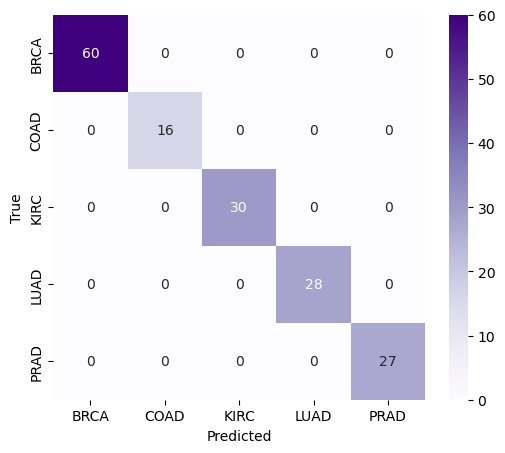

In [45]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = svm_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=le.classes_))

#Plotting confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap="Purples")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Creating PCA Plots

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)   

#Bringing PCA down to two components 
pca = PCA(n_components=2, random_state=21)
X_pca = pca.fit_transform(X_scaled)  

#Making pca data into a dataframe 
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y['Class'].values

#Crating a plot having each label 
plt.figure(figsize=(8,6))
for label in pca_df['Class'].unique():
    subset = pca_df[pca_df['Class'] == label]
    plt.scatter(subset['PC1'], subset['PC2'], label=label, alpha=0.7, s=50)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

### Dimensionality Reduction 

In [110]:
from sklearn.feature_selection import SelectKBest, f_classif

#From running SelectKBest orginally there were some constants so I will remove them. 
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold()
X_nonconstant = vt.fit_transform(X)

#Selecting the best 1000 features 
selector = SelectKBest(score_func=f_classif, k=1000)
X_reduced = selector.fit_transform(X_nonconstant, y_encoded)

print("Original features:", X.shape[1])
print("Reduced features:", X_reduced.shape[1])

Original features: 20531
Reduced features: 1000


### Cross-Validation

In [113]:
#Comparing linear to rbf performance on reduced features 

from sklearn.model_selection import cross_val_score, StratifiedKFold

svm_linear = SVC(kernel='linear', C=1, random_state=21)
svm_rbf = SVC(kernel='rbf', C=1, gamma='scale', random_state=21)


cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=21)

#Linear
scores_linear = cross_val_score(svm_linear, X_reduced, y_encoded, cv=cv, scoring='accuracy')
print("Linear SVM CV accuracy:", np.mean(scores_linear))

# RBF 
scores_rbf = cross_val_score(svm_rbf, X_reduced, y_encoded, cv=cv, scoring='accuracy')
print("RBF SVM CV accuracy:", np.mean(scores_rbf))

Linear SVM CV accuracy: 0.99875
RBF SVM CV accuracy: 0.9974999999999999


### Further Dimensionality reduction

In [157]:
#Using 1000 genes still performed nearly perfect. Maybe even fewer genes are just as informative

#I will stick to linear as it overall outperformed rbf.

#Looping over some values to see how the 
for k in [50, 200, 500]:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_reduced = selector.fit_transform(X_nonconstant, y_encoded)
    scores = cross_val_score(svm_linear, X_reduced, y_encoded, cv=cv, scoring='accuracy')
    print(f"Linear SVM CV accuracy for top {k} genes: {np.mean(scores):.4f}")


Linear SVM CV accuracy for top 50 genes: 1.0000
Linear SVM CV accuracy for top 200 genes: 0.9988
Linear SVM CV accuracy for top 500 genes: 0.9975


### Plotting Top 50 Genes by F score 

['ACP6|51205', 'ACSL6|23305', 'ACSM1|116285', 'AGXT2L1|64850', 'BHLHE41|79365', 'C14orf102|55051', 'C17orf71|55181', 'C20orf141|128653', 'CDH13|1012', 'CDHR3|222256', 'CDT1|81620', 'CHRNA10|57053', 'CLRN1|7401', 'FUT6|2528', 'GLTPD2|388323', 'GOSR1|9527', 'GRASP|160622', 'HIST2H2BF|440689', 'HMGXB3|22993', 'HMGXB4|10042', 'KLHL36|79786', 'KLHL38|340359', 'LINGO3|645191', 'NAP1L5|266812', 'NIPAL4|348938', 'OTOL1|131149', 'P2RX4|5025', 'P2RX5|5026', 'PATE4|399968', 'POP4|10775', 'PPP3CC|5533', 'PRKY|5616', 'QTRT1|81890', 'SFMBT2|57713', 'SFN|2810', 'SFPQ|6421', 'SFRP2|6423', 'SLC12A3|6559', 'SLC12A5|57468', 'SLC17A8|246213', 'SLC25A36|55186', 'SLC25A5|292', 'SLC35F2|54733', 'SLC36A2|153201', 'SLC38A8|146167', 'SLC46A1|113235', 'TESC|54997', 'TTLL4|9654', 'TTL|150465', 'TWF2|11344']


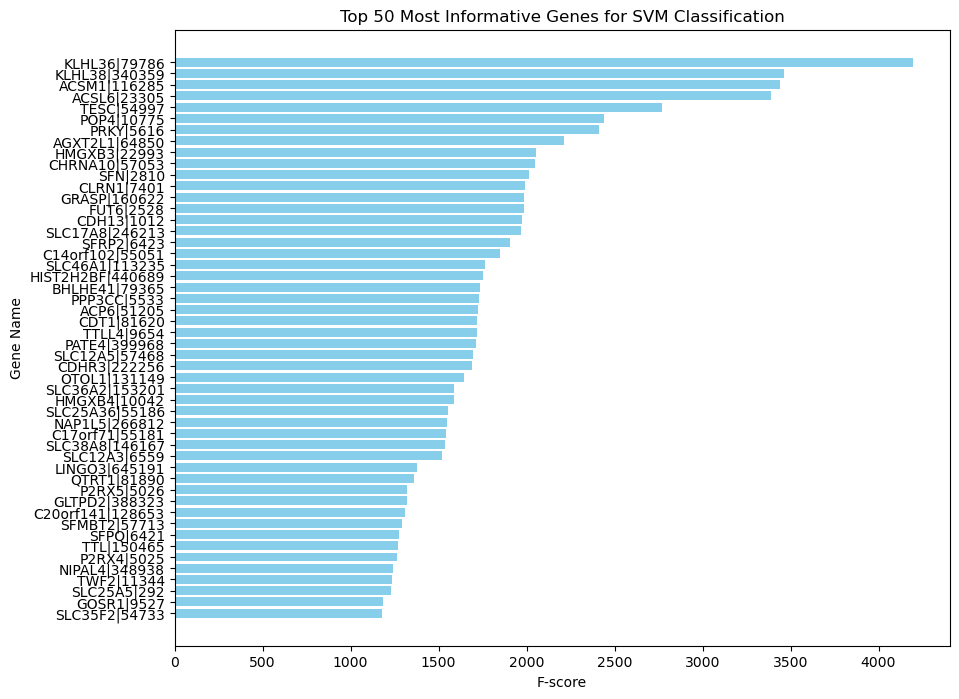

In [177]:
#Even the top 50 genes are great predictors 

# Select top 50 genes
selector_50 = SelectKBest(score_func=f_classif, k=50)
X_reduced_50 = selector_50.fit_transform(X_nonconstant, y_encoded)

# Get indices top 50 
feature_indices = selector_50.get_support(indices=True)

# Get F-scores for the top 50 
f_scores_selected = selector_50.scores_[feature_indices]



#Reading the gene names file and selecting the gene names column. 
gene_names_df = pd.read_csv(
    "unc.edu_PANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv",
    sep='\t',
    usecols=[0] 
)

#Converting to a list 
gene_names = gene_names_df.iloc[:, 0].tolist()

#Getting gene names by index 
top_50_indices = selector_50.get_support(indices=True)
top_50_gene_names = [gene_names[i] for i in top_50_indices]

print(top_50_gene_names)

# Making it a DataFrame for plotting 
gene_importance = pd.DataFrame({
    'Gene': top_50_gene_names,
    'F_score': f_scores_selected
})

# Sorting by descending
gene_importance = gene_importance.sort_values(by='F_score', ascending=False)

# Plotting
plt.figure(figsize=(10,8))
plt.barh(gene_importance['Gene'].astype(str), gene_importance['F_score'], color='skyblue')
plt.xlabel("F-score")
plt.ylabel("Gene Name")
plt.title("Top 50 Most Informative Genes for SVM Classification")
plt.gca().invert_yaxis()
plt.show()
